In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [236]:
Sellers = pd.read_csv('CleanedDataSets/sellers_c.csv')

In [3]:
# Split sellers into seller id and features dataframes
s_id = Sellers[[
    'seller_id',
]]
features = Sellers[[
    'review_score',
    'total_sales',
    'total_revenue',
    'average_frequency',
    'main_product_ratio',
]]

In [4]:
# Initializae a standardization object and fit it to our features.
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [5]:
# Run the kmeans algorithm 10 times with an increasing k, with this we will create an elbow graph of the Sum of
# Squares error of each clustering iteration to decide the proper k.

# We will initialize random cluster centers, with max iterations of 300
kmeans_kwargs = {
   "init": "random",
   "n_init": 10,
   "max_iter": 300,
   "random_state": 42,
}
sse = []
for k in range(1, 11):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(scaled_features)
  sse.append(kmeans.inertia_)

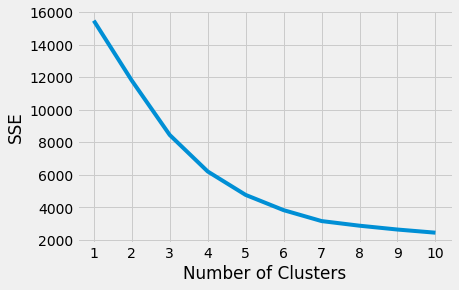

In [6]:
# plot the Elbow chart
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [7]:
# The chart shows a level off at around k=4
kmeans = KMeans(
  init="random",
  n_clusters=4,
  n_init=10,
  max_iter=300,
  random_state=42
)
kmeans.fit(scaled_features)
sse.append(kmeans.inertia_)

In [237]:
# Insert the cluster labels back into the Sellers dataset
Sellers['cluster'] = kmeans.labels_


In [238]:
# Creating a blank dataframe named 'Cluster'
clusters = {'cluster': [0,1,2,3]}
clusters = pd.DataFrame(data=clusters)

In [239]:
# We will now fill the Cluster dataframe with descriptive statistics for each variable that went into the clustering
# algorithm along with other variables not used.

In [240]:
# Cluster Proportions <proportion> 
# Getting the percent of sellers that make up each cluster.
proportion = pd.DataFrame(Sellers.groupby(by=['cluster'])['cluster'].count())
total_sellers = Sellers.seller_id.count()
proportion.rename(columns={'cluster':'proportion'},inplace=True)
proportion.proportion = proportion.proportion / total_sellers
porportion = proportion.reset_index()
clusters = clusters.set_index('cluster').join(proportion.reset_index().set_index('cluster')).reset_index()

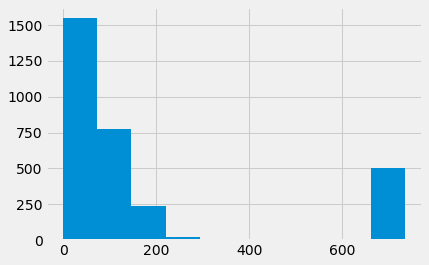

In [241]:
Sellers['average_frequency'].hist()
# Bimodal / right skewed distribution, median measure of center will be used

In [242]:
# Average Cluster Sale Frequency (Days) <average_frequency>
average_frequency = pd.DataFrame(Sellers.groupby(by='cluster')['average_frequency'].median().reset_index())
clusters = clusters.set_index('cluster').join(average_frequency.set_index('cluster')).reset_index()

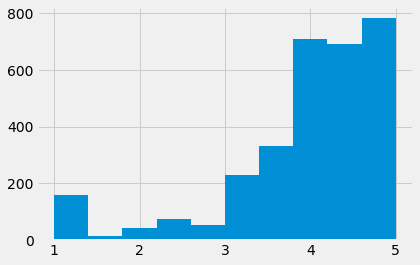

In [243]:
Sellers['review_score'].hist()
# Left Skewed distribution, median measure of center will be used

In [244]:
# Average Cluster Review Score <review_score>
review_score = pd.DataFrame(Sellers.groupby(by='cluster')['review_score'].median().reset_index())
clusters = clusters.set_index('cluster').join(review_score.set_index('cluster')).reset_index()

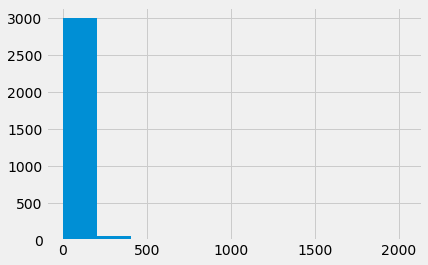

In [245]:
Sellers['total_sales'].hist()
# Right skewed distribution, median measure of center will be used.

In [246]:
# Cluster's Total Sales <total_sales>
total_sales = pd.DataFrame(Sellers.groupby(by='cluster')['total_sales'].sum().reset_index())
clusters = clusters.set_index('cluster').join(total_sales.set_index('cluster')).reset_index()

In [247]:
# Cluster's Average Total Sales <average_total_sales>
average_total_sales = pd.DataFrame(Sellers.groupby(by='cluster')['total_sales'].median().reset_index())
average_total_sales.rename(columns={'total_sales':'average_total_sales'},inplace=True)
clusters = clusters.set_index('cluster').join(average_total_sales.set_index('cluster')).reset_index()

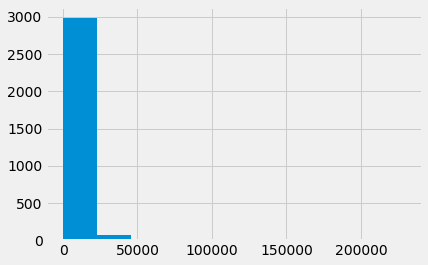

In [248]:
Sellers['total_revenue'].hist()
# Right skewed distribution, median measure of center will be used.

In [249]:
# Cluster's Total Revenue <total_revenue>

total_revenue = pd.DataFrame(Sellers.groupby(by='cluster')['total_revenue'].sum().reset_index())
clusters = clusters.set_index('cluster').join(total_revenue.set_index('cluster')).reset_index()

In [250]:
# Cluster's Average Total Revenue <average_total_revenue>

average_total_revenue = pd.DataFrame(Sellers.groupby(by='cluster')['total_revenue'].median().reset_index())
average_total_revenue.rename(columns={'total_revenue':'average_total_revenue'},inplace=True)
clusters = clusters.set_index('cluster').join(average_total_revenue.set_index('cluster')).reset_index()

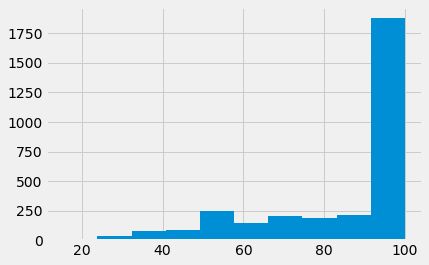

In [251]:
Sellers['main_product_ratio'].hist()
# Left Skewed distribution, mean will be used as it is a ratio.

In [252]:
# Specialization / Main Product Ratio of clusters <main_product_ratio>

# This will tell use what percent of their total sales are made up of their most common product.
specialization = pd.DataFrame(Sellers.groupby(by='cluster')['main_product_ratio'].mean().reset_index())
clusters = clusters.set_index('cluster').join(specialization.set_index('cluster')).reset_index()

In [253]:
# Dropped Off
dropped_off = pd.DataFrame(Sellers.groupby(by='cluster')['total_sales'].count().reset_index())
dropped_off.rename(columns={'total_sales':'total_sellers'},inplace=True)
dropped_off['dropped_off'] = Sellers.loc[Sellers.dropped_off == True].groupby(by='cluster')['dropped_off'].count()
dropped_off.fillna(value=0,inplace=True)
dropped_off.dropped_off[1] = 506
dropped_off.rename(columns={'dropped_off':'dropped_off_count'},inplace=True)
dropped_off['dropped_off'] = dropped_off['dropped_off_count'] / dropped_off['total_sellers']
clusters = clusters.set_index('cluster').join(dropped_off[['cluster','dropped_off']].set_index('cluster')).reset_index()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [254]:
# Price per order
Sellers['price_per_order'] = Sellers['total_revenue'] / Sellers['total_sales']
clusters['price_per_order'] = Sellers.groupby('cluster')['price_per_order'].mean()

In [255]:
# Printed Cluster DataFrame
clusters

,cluster,proportion,average_frequency,review_score,total_sales,average_total_sales,total_revenue,average_total_revenue,main_product_ratio,dropped_off,price_per_order
0,0,0.007108,123.801117,4.044440,24534,1151.5,2911935.51,125787.005,77.095572,0.000000,166.287230
1,1,0.163489,735.000000,5.000000,507,1.0,115303.40,91.000,100.000000,1.000000,227.146245
2,2,0.545719,53.062500,4.142857,54400,9.0,6809099.23,1080.000,96.500577,0.542925,176.856300
3,3,0.283683,62.561858,4.111111,33481,12.0,3779454.32,1400.500,55.877747,0.478360,146.252333


In [256]:
# Transpose cluster dataframe and save it into <cluster_info>
clusters.set_index('cluster')
cluster_info = clusters.T

In [257]:
# Save Full sellers dataset with clusters
Sellers.to_csv('CleanedDataSets/SellersClustering.csv')

# Save cluster table
cluster_info.to_csv('CleanedDatasets/cluster_sellers.csv')

In [258]:
# Creating a PCA for 2 dimensional visualization
pca = PCA(n_components=5)
pca.fit(scaled_features)
V = pca.components_.T

In [259]:
x = pca.transform(scaled_features)

Text(0, 0.5, 'pc2')

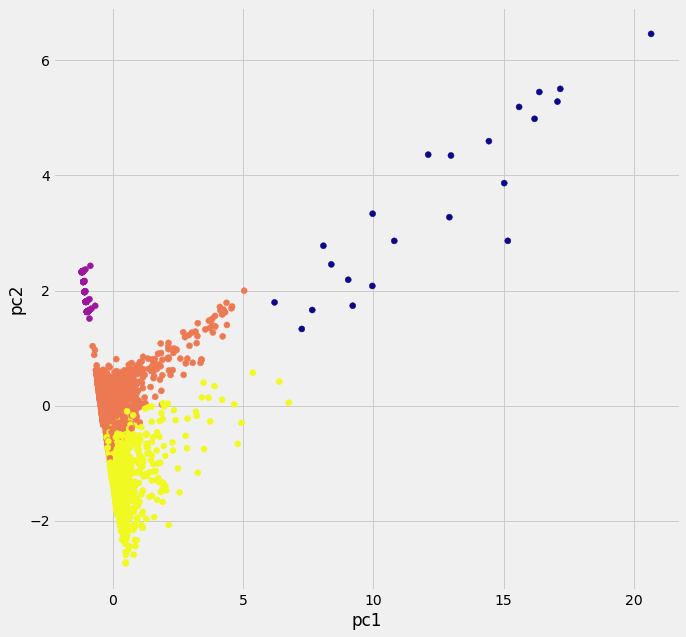

In [260]:
# Plotting the variables along principal components 1 and 2 and coloring based off of Cluster. NOT USED
plt.figure(figsize=(10,10))
plt.scatter(x[:,0],x[:,1],c=Sellers['cluster'],cmap='plasma')
plt.xlabel('pc1')
plt.ylabel('pc2')

AxesSubplot(0.08,0.07;0.87x0.81)
385     AC
2366    AM
2685    BA
1180    BA
2193    BA
        ..
1292    SP
1294    SP
1297    SP
1196    SP
3094    SP
Name: seller_state, Length: 3095, dtype: object


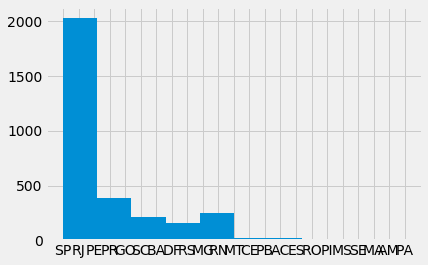

In [87]:
def print_stuff(var):
    print(var.hist())
    print(var.sort_values())
    
var = Sellers.seller_state

print_stuff(var)

In [95]:
def print_cat(var):
    print(len(var.unique()))
    #print(var.mode())
    
var = Sellers.favorite_product

print_cat(var)

68


In [207]:
# Getting the top 5 products for each cluster.
s = Sellers['favorite_product'].groupby(Sellers['cluster']).value_counts()
s = pd.DataFrame(s)
s.rename(columns={'favorite_product':'count'},inplace=True)
s = s.reset_index()
s_pivot = s.pivot_table(index='favorite_product', columns='cluster', values='count')
c0 = s_pivot[0]
c1 = s_pivot[1]
c2 = s_pivot[2]
c3 = s_pivot[3]
c0 = pd.DataFrame(c0).rename(columns={0:'count'})
c1 = pd.DataFrame(c1).rename(columns={1:'count'})
c2 = pd.DataFrame(c2).rename(columns={2:'count'})
c3 = pd.DataFrame(c3).rename(columns={3:'count'})
c0 = c0.reset_index().dropna().sort_values('count',ascending=False)
c1 = c1.reset_index().dropna().sort_values('count',ascending=False)
c2 = c2.reset_index().dropna().sort_values('count',ascending=False)
c3 = c3.reset_index().dropna().sort_values('count',ascending=False)
c0 = c0[['favorite_product','count']][0:5]
c1 = c1[['favorite_product','count']][0:5]
c2 = c2[['favorite_product','count']][0:5]
c3 = c3[['favorite_product','count']][0:5]